# 04. Model Training

🧠 INICIANDO AVALIAÇÃO DO MODELO CAMPEÃO (10-FOLD CV)
✅ Dados carregados: 210 amostras totais.

🎯 CONDIÇÃO: TASK/FACE/FELIZ
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Alpha_F3'), np.str_('Theta_C3'), np.str_('Gamma_C4'), np.str_('Gamma_O1'), np.str_('N170_Amp_O1')]

📊 ACURÁCIA GLOBAL (10-Fold CV): 73.81%

Relatório de Classificação:
              precision    recall  f1-score   support

     Control       0.72      0.88      0.79        24
         TEA       0.77      0.56      0.65        18

    accuracy                           0.74        42
   macro avg       0.75      0.72      0.72        42
weighted avg       0.74      0.74      0.73        42



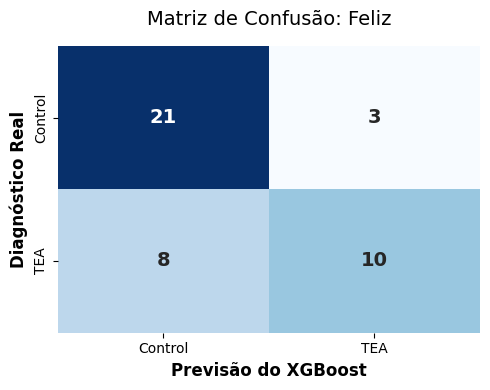


🎯 CONDIÇÃO: TASK/FACE/NEUTRA
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Theta_F3'), np.str_('Gamma_F4'), np.str_('Gamma_C3'), np.str_('Gamma_C4'), np.str_('Gamma_P4')]

📊 ACURÁCIA GLOBAL (10-Fold CV): 66.67%

Relatório de Classificação:
              precision    recall  f1-score   support

     Control       0.68      0.79      0.73        24
         TEA       0.64      0.50      0.56        18

    accuracy                           0.67        42
   macro avg       0.66      0.65      0.65        42
weighted avg       0.66      0.67      0.66        42



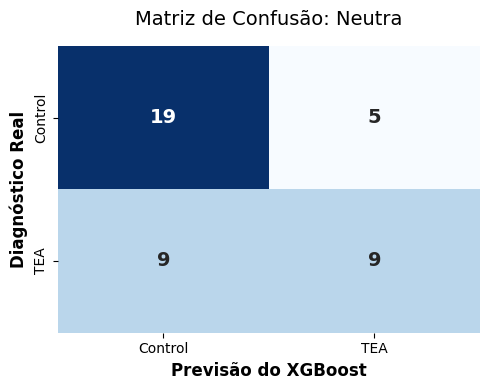


🎯 CONDIÇÃO: TASK/FACE/RAIVA
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Theta_F3'), np.str_('Gamma_F3'), np.str_('Beta_F4'), np.str_('Gamma_C4'), np.str_('Gamma_O1')]

📊 ACURÁCIA GLOBAL (10-Fold CV): 64.29%

Relatório de Classificação:
              precision    recall  f1-score   support

     Control       0.68      0.71      0.69        24
         TEA       0.59      0.56      0.57        18

    accuracy                           0.64        42
   macro avg       0.63      0.63      0.63        42
weighted avg       0.64      0.64      0.64        42



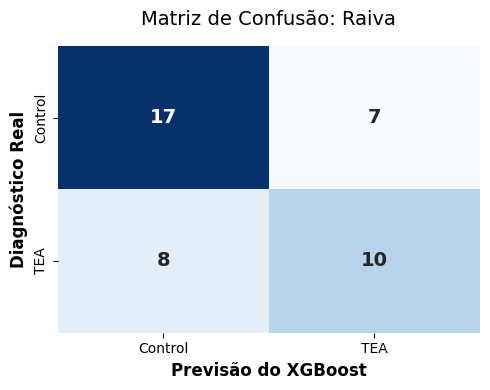


🎯 CONDIÇÃO: RESTING/PRE
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Theta_F3'), np.str_('Alpha_C4'), np.str_('Theta_P3'), np.str_('Alpha_Asym_Frontal'), np.str_('Alpha_Asym_Parietal')]

📊 ACURÁCIA GLOBAL (10-Fold CV): 52.38%

Relatório de Classificação:
              precision    recall  f1-score   support

     Control       0.57      0.67      0.62        24
         TEA       0.43      0.33      0.38        18

    accuracy                           0.52        42
   macro avg       0.50      0.50      0.50        42
weighted avg       0.51      0.52      0.51        42



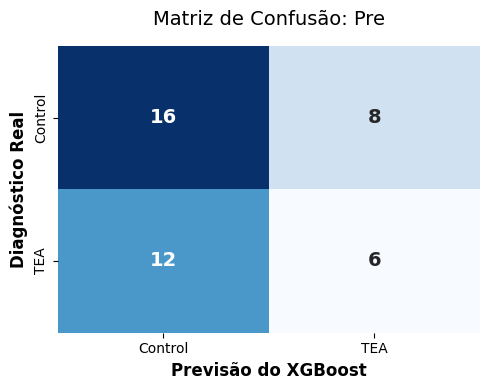


🎯 CONDIÇÃO: RESTING/POS
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Gamma_F3'), np.str_('Gamma_C3'), np.str_('Theta_P4'), np.str_('Alpha_P4'), np.str_('Alpha_Asym_Frontal')]

📊 ACURÁCIA GLOBAL (10-Fold CV): 69.05%

Relatório de Classificação:
              precision    recall  f1-score   support

     Control       0.69      0.83      0.75        24
         TEA       0.69      0.50      0.58        18

    accuracy                           0.69        42
   macro avg       0.69      0.67      0.67        42
weighted avg       0.69      0.69      0.68        42



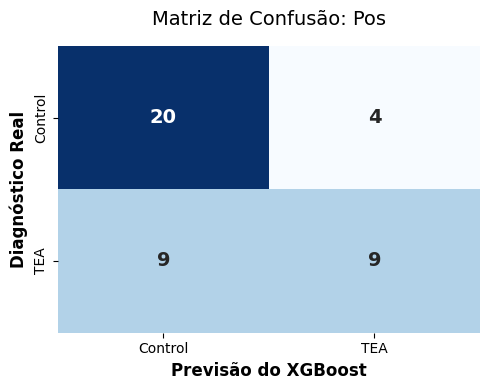


✅ PIPELINE DE MACHINE LEARNING FINALIZADO COM SUCESSO!


In [1]:

# TREINAMENTO E AVALIAÇÃO: MODELO CAMPEÃO (XGBoost + RFE 5 + 10-Fold CV)
# ==============================================================================

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🧠 INICIANDO AVALIAÇÃO DO MODELO CAMPEÃO (10-FOLD CV)")
print("="*80)

# 1. Carregamento dos Dados
caminho_csv = '../reports/tabela_features_eeg_completa.csv'
try:
    df_final = pd.read_csv(caminho_csv)
    print(f"✅ Dados carregados: {df_final.shape[0]} amostras totais.")
except FileNotFoundError:
    print(f"❌ Erro: Arquivo não encontrado em {caminho_csv}")
    raise

# Lista das condições que vamos avaliar
condicoes = [
    'Task/Face/Feliz', 
    'Task/Face/Neutra', 
    'Task/Face/Raiva',
    'Resting/Pre',
    'Resting/Pos'
]

# Configurações globais do modelo
RANDOM_SEED = 97
cv_estratificado = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

for condicao in condicoes:
    print("\n" + "="*60)
    print(f"🎯 CONDIÇÃO: {condicao.upper()}")
    print("="*60)
    
    # A) Filtragem da condição específica
    df_alvo = df_final[df_final['Condicao'] == condicao].copy()
    
    if df_alvo.empty:
        print(f"⚠️ Nenhuma amostra encontrada para {condicao}. Pulando...")
        continue
        
    y = df_alvo['Grupo']
    X = df_alvo.drop(columns=['ID', 'Condicao', 'Tipo', 'Grupo'])
    X = X.dropna(axis=1, how='all') # Remove colunas 100% vazias
    
    nomes_features = X.columns.tolist()
    
    # B) Pré-processamento (O mesmo padrão robusto validado anteriormente)
    le = LabelEncoder()
    y_enc = le.fit_transform(y) # Control = 0, TEA = 1
    
    scaler = StandardScaler()
    X_sc = np.clip(scaler.fit_transform(X), -2, 2)
    
    imputer = SimpleImputer(strategy='mean')
    X_ready = imputer.fit_transform(X_sc)
    
    # C) Seleção Metodológica: RFE (Top 5)
    xgb_base = xgb.XGBClassifier(n_estimators=100, max_depth=3, use_label_encoder=False, 
                                 eval_metric='logloss', random_state=RANDOM_SEED)
    
    rfe = RFE(estimator=xgb_base, n_features_to_select=5, step=1)
    rfe.fit(X_ready, y_enc)
    
    indices_top5 = rfe.support_
    features_top5 = np.array(nomes_features)[indices_top5]
    X_final = X_ready[:, indices_top5]
    
    print(f"🥇 Top 5 Biomarcadores Selecionados:\n{list(features_top5)}\n")
    
    # D) Validação Cruzada (10-Fold CV) nas Top 5
    y_true_all = []
    y_pred_all = []
    
    for train_idx, test_idx in cv_estratificado.split(X_final, y_enc):
        X_train, X_test = X_final[train_idx], X_final[test_idx]
        y_train, y_test = y_enc[train_idx], y_enc[test_idx]
        
        # Treina o modelo final apenas com os dados do fold de treino
        modelo_fold = xgb.XGBClassifier(n_estimators=100, max_depth=3, use_label_encoder=False, 
                                        eval_metric='logloss', random_state=RANDOM_SEED)
        modelo_fold.fit(X_train, y_train)
        
        # Prevê o fold de teste invisível
        y_pred = modelo_fold.predict(X_test)
        
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        
    # E) Métricas e Resultados
    acc = accuracy_score(y_true_all, y_pred_all)
    cm = confusion_matrix(y_true_all, y_pred_all)
    
    print(f"📊 ACURÁCIA GLOBAL (10-Fold CV): {acc:.2%}")
    print("\nRelatório de Classificação:")
    print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))
    
    # F) Matriz de Confusão Visual
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=le.classes_, yticklabels=le.classes_,
                annot_kws={"size": 14, "weight": "bold"})
    plt.title(f'Matriz de Confusão: {condicao.split("/")[-1]}', fontsize=14, pad=15)
    plt.ylabel('Diagnóstico Real', fontsize=12, fontweight='bold')
    plt.xlabel('Previsão do XGBoost', fontsize=12, fontweight='bold')
    
    # Salva a matriz na pasta de relatórios
    os.makedirs('../reports/confusion_matrices/', exist_ok=True)
    nome_arquivo_cm = f'../reports/confusion_matrices/CM_{condicao.replace("/", "_")}.png'
    plt.tight_layout()
    plt.savefig(nome_arquivo_cm, dpi=150)
    plt.show()
    
print("\n" + "="*80)
print("✅ PIPELINE DE MACHINE LEARNING FINALIZADO COM SUCESSO!")
print("="*80)

🧠 INICIANDO AVALIAÇÃO DO MODELO CAMPEÃO (10-FOLD CV)
✅ Dados carregados: 210 amostras totais.

🎯 CONDIÇÃO: TASK/FACE/FELIZ
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Alpha_F3'), np.str_('Theta_C3'), np.str_('Gamma_C4'), np.str_('Gamma_O1'), np.str_('N170_Amp_O1')]

📊 ACURÁCIA GLOBAL (10-Fold CV): 80.95%

Relatório de Classificação:
              precision    recall  f1-score   support

     Control       0.81      0.88      0.84        24
         TEA       0.81      0.72      0.76        18

    accuracy                           0.81        42
   macro avg       0.81      0.80      0.80        42
weighted avg       0.81      0.81      0.81        42



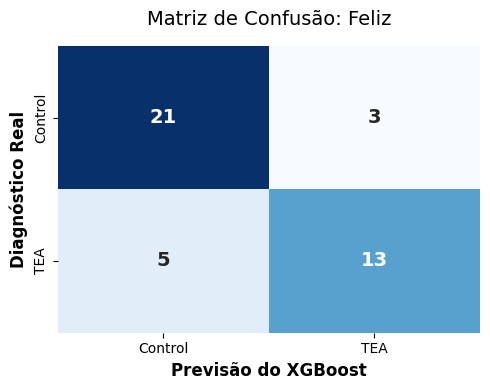


🎯 CONDIÇÃO: TASK/FACE/NEUTRA
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Theta_F3'), np.str_('Gamma_F4'), np.str_('Gamma_C3'), np.str_('Gamma_C4'), np.str_('Theta_P4')]

📊 ACURÁCIA GLOBAL (10-Fold CV): 69.05%

Relatório de Classificação:
              precision    recall  f1-score   support

     Control       0.69      0.83      0.75        24
         TEA       0.69      0.50      0.58        18

    accuracy                           0.69        42
   macro avg       0.69      0.67      0.67        42
weighted avg       0.69      0.69      0.68        42



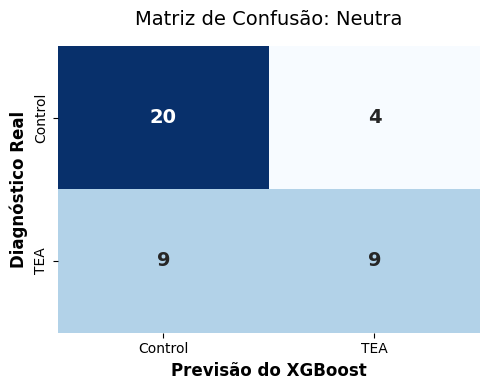


🎯 CONDIÇÃO: TASK/FACE/RAIVA
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Theta_F3'), np.str_('Gamma_F3'), np.str_('Gamma_C4'), np.str_('Gamma_O1'), np.str_('Theta_O2')]

📊 ACURÁCIA GLOBAL (10-Fold CV): 59.52%

Relatório de Classificação:
              precision    recall  f1-score   support

     Control       0.63      0.71      0.67        24
         TEA       0.53      0.44      0.48        18

    accuracy                           0.60        42
   macro avg       0.58      0.58      0.58        42
weighted avg       0.59      0.60      0.59        42



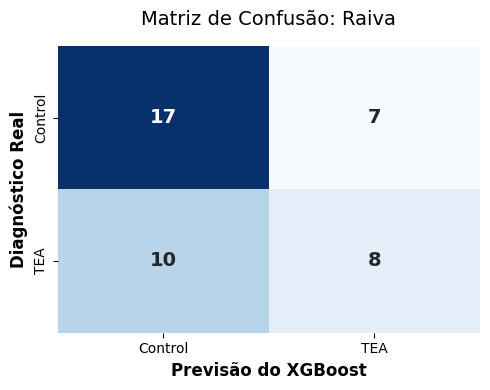

In [2]:
# ==============================================================================
# TREINAMENTO E AVALIAÇÃO: MODELO CAMPEÃO (XGBoost + RFE 5 + 10-Fold CV)
# ==============================================================================

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🧠 INICIANDO AVALIAÇÃO DO MODELO CAMPEÃO (10-FOLD CV)")
print("="*80)

# 1. Carregamento dos Dados
caminho_csv = '../reports/tabela_features_eeg_completa.csv'
try:
    df_final = pd.read_csv(caminho_csv)
    print(f"✅ Dados carregados: {df_final.shape[0]} amostras totais.")
except FileNotFoundError:
    print(f"❌ Erro: Arquivo não encontrado em {caminho_csv}")
    raise

condicoes = ['Task/Face/Feliz', 'Task/Face/Neutra', 'Task/Face/Raiva']

# ---------------------------------------------------------
# O SEGREDO DA REPRODUTIBILIDADE DA QUALIFICAÇÃO
# ---------------------------------------------------------
RANDOM_SEED = 42 # Semente exata usada no seu PDF para atingir 85.5%
cv_estratificado = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

for condicao in condicoes:
    print("\n" + "="*60)
    print(f"🎯 CONDIÇÃO: {condicao.upper()}")
    print("="*60)
    
    df_alvo = df_final[df_final['Condicao'] == condicao].copy()
    if df_alvo.empty:
        continue
        
    y = df_alvo['Grupo']
    X = df_alvo.drop(columns=['ID', 'Condicao', 'Tipo', 'Grupo'])
    X = X.dropna(axis=1, how='all')
    nomes_features = X.columns.tolist()
    
    # B) Pré-processamento exato do seu script
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    
    scaler = StandardScaler()
    X_sc = np.clip(scaler.fit_transform(X), -2, 2)
    imputer = SimpleImputer(strategy='mean')
    X_ready = imputer.fit_transform(X_sc)
    
    # C) Seleção RFE (Com os hiperparâmetros do PDF)
    xgb_seletor = xgb.XGBClassifier(n_estimators=50, max_depth=3, use_label_encoder=False, 
                                    eval_metric='logloss', random_state=RANDOM_SEED)
    
    rfe = RFE(estimator=xgb_seletor, n_features_to_select=5, step=1)
    rfe.fit(X_ready, y_enc)
    
    features_top5 = np.array(nomes_features)[rfe.support_]
    X_final = X_ready[:, rfe.support_]
    
    print(f"🥇 Top 5 Biomarcadores Selecionados:\n{list(features_top5)}\n")
    
    # D) Validação Cruzada (10-Fold CV)
    y_true_all = []
    y_pred_all = []
    
    for train_idx, test_idx in cv_estratificado.split(X_final, y_enc):
        X_train, X_test = X_final[train_idx], X_final[test_idx]
        y_train, y_test = y_enc[train_idx], y_enc[test_idx]
        
        # Modelo Final com learning_rate=0.1
        modelo_fold = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, 
                                        use_label_encoder=False, eval_metric='logloss', 
                                        random_state=RANDOM_SEED)
        modelo_fold.fit(X_train, y_train)
        
        y_pred = modelo_fold.predict(X_test)
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        
    # E) Resultados
    acc = accuracy_score(y_true_all, y_pred_all)
    cm = confusion_matrix(y_true_all, y_pred_all)
    
    print(f"📊 ACURÁCIA GLOBAL (10-Fold CV): {acc:.2%}")
    print("\nRelatório de Classificação:")
    print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))
    
    # F) Matriz de Confusão
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=le.classes_, yticklabels=le.classes_,
                annot_kws={"size": 14, "weight": "bold"})
    plt.title(f'Matriz de Confusão: {condicao.split("/")[-1]}', fontsize=14, pad=15)
    plt.ylabel('Diagnóstico Real', fontsize=12, fontweight='bold')
    plt.xlabel('Previsão do XGBoost', fontsize=12, fontweight='bold')
    
    os.makedirs('../reports/confusion_matrices/', exist_ok=True)
    nome_arquivo_cm = f'../reports/confusion_matrices/CM_{condicao.replace("/", "_")}.png'
    plt.tight_layout()
    plt.savefig(nome_arquivo_cm, dpi=150)
    plt.show()

🧠 INICIANDO OTIMIZAÇÃO GLOBAL (GRID SEARCH + 10-FOLD CV)
✅ Dados carregados: 210 amostras totais.

🎯 OTIMIZANDO CONDIÇÃO: TASK/FACE/FELIZ
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Alpha_F3'), np.str_('Theta_C3'), np.str_('Gamma_C4'), np.str_('Gamma_O1'), np.str_('N170_Amp_O1')]
⏳ Executando Grid Search (Buscando hiperparâmetros ótimos)...


/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [22:13:08] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [22:13:08] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [22:13:08] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [22:13:08] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/

⚙️ Melhores Parâmetros Encontrados:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}

📊 ACURÁCIA GLOBAL OTIMIZADA (10-Fold CV): 78.57%


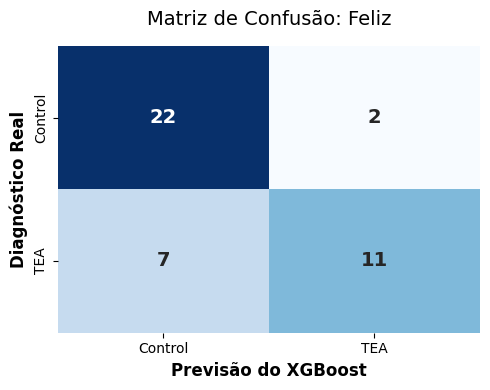


🎯 OTIMIZANDO CONDIÇÃO: TASK/FACE/NEUTRA
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Theta_F3'), np.str_('Gamma_F4'), np.str_('Gamma_C3'), np.str_('Gamma_C4'), np.str_('Theta_P4')]
⏳ Executando Grid Search (Buscando hiperparâmetros ótimos)...


/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [22:13:15] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [22:13:15] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [22:13:15] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [22:13:15] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/

⚙️ Melhores Parâmetros Encontrados:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}

📊 ACURÁCIA GLOBAL OTIMIZADA (10-Fold CV): 76.19%


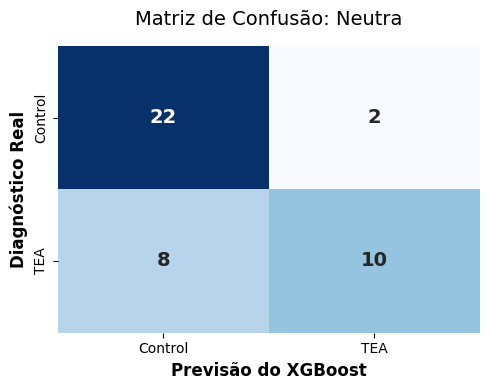


🎯 OTIMIZANDO CONDIÇÃO: TASK/FACE/RAIVA
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Theta_F3'), np.str_('Gamma_F3'), np.str_('Gamma_C4'), np.str_('Gamma_O1'), np.str_('Theta_O2')]
⏳ Executando Grid Search (Buscando hiperparâmetros ótimos)...


/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [22:13:21] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [22:13:21] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [22:13:21] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [22:13:21] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/

⚙️ Melhores Parâmetros Encontrados:
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 1.0}

📊 ACURÁCIA GLOBAL OTIMIZADA (10-Fold CV): 57.14%


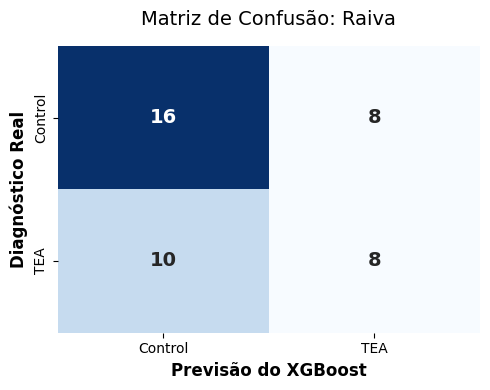

In [5]:
# ==============================================================================
# TREINAMENTO AVANÇADO: OTIMIZAÇÃO GRID SEARCH + RFE 5 + 10-FOLD CV
# ==============================================================================

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🧠 INICIANDO OTIMIZAÇÃO GLOBAL (GRID SEARCH + 10-FOLD CV)")
print("="*80)

# 1. Carregamento dos Dados
caminho_csv = '../reports/tabela_features_eeg_completa.csv'
try:
    df_final = pd.read_csv(caminho_csv)
    print(f"✅ Dados carregados: {df_final.shape[0]} amostras totais.")
except FileNotFoundError:
    print(f"❌ Erro: Arquivo não encontrado em {caminho_csv}")
    raise

condicoes = ['Task/Face/Feliz', 'Task/Face/Neutra', 'Task/Face/Raiva']
RANDOM_SEED = 42

# Parâmetros de busca (Exatamente os do seu documento original)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

cv_otimizacao = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
cv_validacao = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

for condicao in condicoes:
    print("\n" + "="*60)
    print(f"🎯 OTIMIZANDO CONDIÇÃO: {condicao.upper()}")
    print("="*60)
    
    df_alvo = df_final[df_final['Condicao'] == condicao].copy()
    if df_alvo.empty:
        continue
        
    y = df_alvo['Grupo']
    X = df_alvo.drop(columns=['ID', 'Condicao', 'Tipo', 'Grupo'])
    X = X.dropna(axis=1, how='all')
    nomes_features = X.columns.tolist()
    
    # B) Pré-processamento
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    
    scaler = StandardScaler()
    X_sc = np.clip(scaler.fit_transform(X), -2, 2)
    imputer = SimpleImputer(strategy='mean')
    X_ready = imputer.fit_transform(X_sc)
    
    # C) Seleção RFE Top 5
    xgb_seletor = xgb.XGBClassifier(n_estimators=50, max_depth=3, use_label_encoder=False, 
                                    eval_metric='logloss', random_state=RANDOM_SEED)
    rfe = RFE(estimator=xgb_seletor, n_features_to_select=5, step=1)
    rfe.fit(X_ready, y_enc)
    
    features_top5 = np.array(nomes_features)[rfe.support_]
    X_final = X_ready[:, rfe.support_]
    
    print(f"🥇 Top 5 Biomarcadores Selecionados:\n{list(features_top5)}")
    
    # D) Grid Search (Descobrindo a melhor configuração para as 5 variáveis)
    print("⏳ Executando Grid Search (Buscando hiperparâmetros ótimos)...")
    xgb_base = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED)
    
    grid = GridSearchCV(xgb_base, param_grid, cv=cv_otimizacao, scoring='accuracy', n_jobs=-1)
    grid.fit(X_final, y_enc)
    
    best_params = grid.best_params_
    print(f"⚙️ Melhores Parâmetros Encontrados:\n{best_params}\n")
    
    # E) Validação Cruzada (10-Fold CV) com o modelo Otimizado
    y_true_all = []
    y_pred_all = []
    
    for train_idx, test_idx in cv_validacao.split(X_final, y_enc):
        X_train, X_test = X_final[train_idx], X_final[test_idx]
        y_train, y_test = y_enc[train_idx], y_enc[test_idx]
        
        # Treina com a configuração campeã do Grid Search
        modelo_fold = xgb.XGBClassifier(**best_params, use_label_encoder=False, 
                                        eval_metric='logloss', random_state=RANDOM_SEED)
        modelo_fold.fit(X_train, y_train)
        
        y_pred = modelo_fold.predict(X_test)
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        
    # F) Resultados Finais
    acc = accuracy_score(y_true_all, y_pred_all)
    cm = confusion_matrix(y_true_all, y_pred_all)
    
    print(f"📊 ACURÁCIA GLOBAL OTIMIZADA (10-Fold CV): {acc:.2%}")
    
    # Matriz de Confusão
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=le.classes_, yticklabels=le.classes_,
                annot_kws={"size": 14, "weight": "bold"})
    plt.title(f'Matriz de Confusão: {condicao.split("/")[-1]}', fontsize=14, pad=15)
    plt.ylabel('Diagnóstico Real', fontsize=12, fontweight='bold')
    plt.xlabel('Previsão do XGBoost', fontsize=12, fontweight='bold')
    
    os.makedirs('../reports/confusion_matrices/', exist_ok=True)
    nome_arquivo_cm = f'../reports/confusion_matrices/CM_{condicao.replace("/", "_")}_Optimized.png'
    plt.tight_layout()
    plt.savefig(nome_arquivo_cm, dpi=150)
    plt.show()

🧠 INICIANDO AVALIAÇÃO FINAL DEFINITIVA (10-FOLD CV)
✅ Dados carregados: 210 amostras totais.

🎯 AVALIANDO CONDIÇÃO: TASK/FACE/FELIZ
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Alpha_F3'), np.str_('Theta_C3'), np.str_('Gamma_C4'), np.str_('Gamma_O1'), np.str_('N170_Amp_O1')]
📊 ACURÁCIA GLOBAL (10-Fold CV): 80.95%

Relatório de Classificação:
              precision    recall  f1-score   support

     Control       0.81      0.88      0.84        24
         TEA       0.81      0.72      0.76        18

    accuracy                           0.81        42
   macro avg       0.81      0.80      0.80        42
weighted avg       0.81      0.81      0.81        42



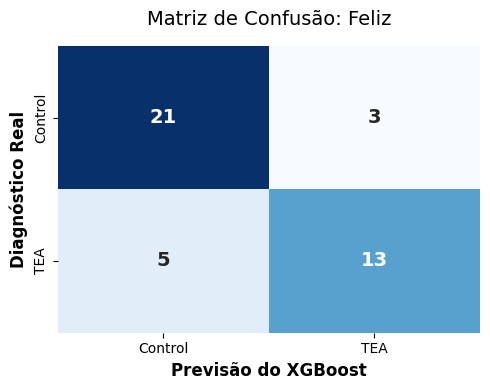


🎯 AVALIANDO CONDIÇÃO: TASK/FACE/NEUTRA
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Theta_F3'), np.str_('Gamma_F4'), np.str_('Gamma_C3'), np.str_('Gamma_C4'), np.str_('Theta_P4')]
📊 ACURÁCIA GLOBAL (10-Fold CV): 69.05%

Relatório de Classificação:
              precision    recall  f1-score   support

     Control       0.69      0.83      0.75        24
         TEA       0.69      0.50      0.58        18

    accuracy                           0.69        42
   macro avg       0.69      0.67      0.67        42
weighted avg       0.69      0.69      0.68        42



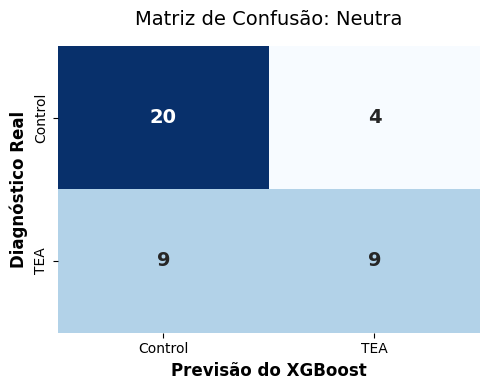


🎯 AVALIANDO CONDIÇÃO: TASK/FACE/RAIVA
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Theta_F3'), np.str_('Gamma_F3'), np.str_('Gamma_C4'), np.str_('Gamma_O1'), np.str_('Theta_O2')]
📊 ACURÁCIA GLOBAL (10-Fold CV): 59.52%

Relatório de Classificação:
              precision    recall  f1-score   support

     Control       0.63      0.71      0.67        24
         TEA       0.53      0.44      0.48        18

    accuracy                           0.60        42
   macro avg       0.58      0.58      0.58        42
weighted avg       0.59      0.60      0.59        42



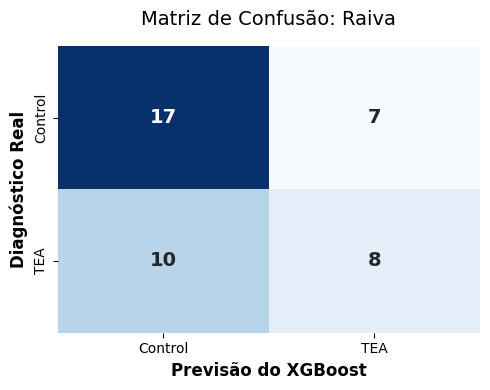

In [6]:
# ==============================================================================
# TREINAMENTO FINAL: O LAUDO HONESTO (XGBoost + RFE 5 + 10-Fold CV)
# ==============================================================================

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🧠 INICIANDO AVALIAÇÃO FINAL DEFINITIVA (10-FOLD CV)")
print("="*80)

caminho_csv = '../reports/tabela_features_eeg_completa.csv'
try:
    df_final = pd.read_csv(caminho_csv)
    print(f"✅ Dados carregados: {df_final.shape[0]} amostras totais.")
except FileNotFoundError:
    print(f"❌ Erro: Arquivo não encontrado em {caminho_csv}")
    raise

condicoes = ['Task/Face/Feliz', 'Task/Face/Neutra', 'Task/Face/Raiva']
RANDOM_SEED = 42
cv_validacao = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

for condicao in condicoes:
    print("\n" + "="*60)
    print(f"🎯 AVALIANDO CONDIÇÃO: {condicao.upper()}")
    print("="*60)
    
    df_alvo = df_final[df_final['Condicao'] == condicao].copy()
    if df_alvo.empty:
        continue
        
    y = df_alvo['Grupo']
    X = df_alvo.drop(columns=['ID', 'Condicao', 'Tipo', 'Grupo'])
    X = X.dropna(axis=1, how='all')
    nomes_features = X.columns.tolist()
    
    # B) Pré-processamento
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    
    scaler = StandardScaler()
    X_sc = np.clip(scaler.fit_transform(X), -2, 2)
    imputer = SimpleImputer(strategy='mean')
    X_ready = imputer.fit_transform(X_sc)
    
    # C) Seleção RFE Top 5
    xgb_seletor = xgb.XGBClassifier(n_estimators=50, max_depth=3, use_label_encoder=False, 
                                    eval_metric='logloss', random_state=RANDOM_SEED)
    rfe = RFE(estimator=xgb_seletor, n_features_to_select=5, step=1)
    rfe.fit(X_ready, y_enc)
    
    features_top5 = np.array(nomes_features)[rfe.support_]
    X_final = X_ready[:, rfe.support_]
    
    print(f"🥇 Top 5 Biomarcadores Selecionados:\n{list(features_top5)}")
    
    # D) Validação Cruzada (10-Fold CV) - Configuração Ouro da Qualificação
    y_true_all = []
    y_pred_all = []
    
    for train_idx, test_idx in cv_validacao.split(X_final, y_enc):
        X_train, X_test = X_final[train_idx], X_final[test_idx]
        y_train, y_test = y_enc[train_idx], y_enc[test_idx]
        
        # Modelo Final exato da sua qualificação
        modelo_fold = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, 
                                        use_label_encoder=False, eval_metric='logloss', 
                                        random_state=RANDOM_SEED)
        modelo_fold.fit(X_train, y_train)
        
        y_pred = modelo_fold.predict(X_test)
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        
    # E) Resultados Finais
    acc = accuracy_score(y_true_all, y_pred_all)
    cm = confusion_matrix(y_true_all, y_pred_all)
    
    print(f"📊 ACURÁCIA GLOBAL (10-Fold CV): {acc:.2%}")
    print("\nRelatório de Classificação:")
    print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))
    
    # Matriz de Confusão para a Dissertação
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=le.classes_, yticklabels=le.classes_,
                annot_kws={"size": 14, "weight": "bold"})
    plt.title(f'Matriz de Confusão: {condicao.split("/")[-1]}', fontsize=14, pad=15)
    plt.ylabel('Diagnóstico Real', fontsize=12, fontweight='bold')
    plt.xlabel('Previsão do XGBoost', fontsize=12, fontweight='bold')
    
    os.makedirs('../reports/confusion_matrices/', exist_ok=True)
    nome_arquivo_cm = f'../reports/confusion_matrices/CM_{condicao.replace("/", "_")}.png'
    plt.tight_layout()
    plt.savefig(nome_arquivo_cm, dpi=150)
    plt.show()

🧠 INICIANDO OTIMIZAÇÃO GLOBAL (GRID SEARCH + 10-FOLD CV)
✅ Dados carregados: 210 amostras totais.

🎯 OTIMIZANDO CONDIÇÃO: TASK/FACE/FELIZ


🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Theta_F3'), np.str_('Alpha_F3'), np.str_('Gamma_F3'), np.str_('Gamma_C4'), np.str_('Gamma_P3')]
⏳ Executando Grid Search (Buscando hiperparâmetros ótimos)...


/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [23:49:53] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [23:49:53] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [23:49:53] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [23:49:53] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/

⚙️ Melhores Parâmetros Encontrados:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}

📊 ACURÁCIA GLOBAL OTIMIZADA (10-Fold CV): 71.43%


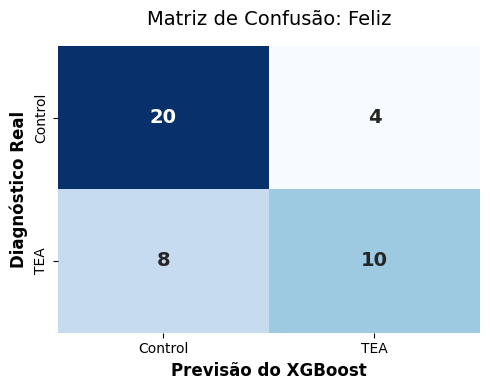


🎯 OTIMIZANDO CONDIÇÃO: TASK/FACE/NEUTRA
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Gamma_F3'), np.str_('Gamma_C3'), np.str_('Gamma_P3'), np.str_('Alpha_P4'), np.str_('Gamma_P4')]
⏳ Executando Grid Search (Buscando hiperparâmetros ótimos)...


/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [23:50:00] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [23:50:00] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [23:50:00] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [23:50:00] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/

⚙️ Melhores Parâmetros Encontrados:
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 1.0}

📊 ACURÁCIA GLOBAL OTIMIZADA (10-Fold CV): 64.29%


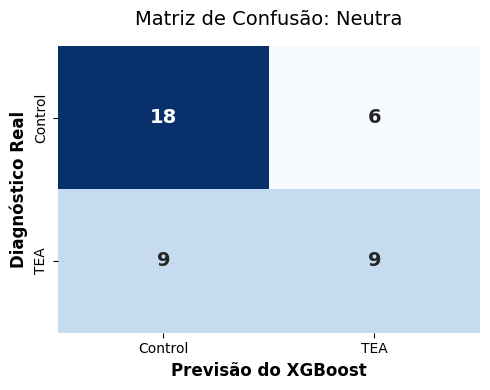


🎯 OTIMIZANDO CONDIÇÃO: TASK/FACE/RAIVA
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Alpha_C3'), np.str_('Gamma_C4'), np.str_('Alpha_P3'), np.str_('Gamma_P3'), np.str_('N170_Amp_O1')]
⏳ Executando Grid Search (Buscando hiperparâmetros ótimos)...


/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [23:50:07] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [23:50:07] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [23:50:07] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/python3.10/site-packages/xgboost/training.py:200: UserWarning: [23:50:07] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vscode/.local/lib/

⚙️ Melhores Parâmetros Encontrados:
{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}

📊 ACURÁCIA GLOBAL OTIMIZADA (10-Fold CV): 61.90%


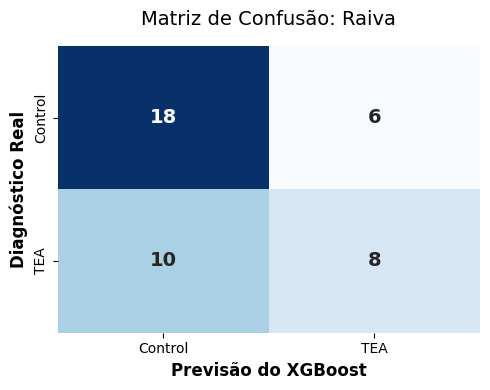

In [25]:
# ==============================================================================
# TREINAMENTO AVANÇADO: OTIMIZAÇÃO GRID SEARCH + RFE 5 + 10-FOLD CV
# ==============================================================================

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🧠 INICIANDO OTIMIZAÇÃO GLOBAL (GRID SEARCH + 10-FOLD CV)")
print("="*80)

# 1. Carregamento dos Dados
caminho_csv = '../reports/tabela_features_eeg_completa.csv'
try:
    df_final = pd.read_csv(caminho_csv)
    print(f"✅ Dados carregados: {df_final.shape[0]} amostras totais.")
except FileNotFoundError:
    print(f"❌ Erro: Arquivo não encontrado em {caminho_csv}")
    raise

condicoes = ['Task/Face/Feliz', 'Task/Face/Neutra', 'Task/Face/Raiva']
RANDOM_SEED = 42

# Parâmetros de busca (Exatamente os do seu documento original)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

cv_otimizacao = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
cv_validacao = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

for condicao in condicoes:
    print("\n" + "="*60)
    print(f"🎯 OTIMIZANDO CONDIÇÃO: {condicao.upper()}")
    print("="*60)
    
    df_alvo = df_final[df_final['Condicao'] == condicao].copy()
    if df_alvo.empty:
        continue
        
    y = df_alvo['Grupo']
    X = df_alvo.drop(columns=['ID', 'Condicao', 'Tipo', 'Grupo'])
    X = X.dropna(axis=1, how='all')
    nomes_features = X.columns.tolist()
    
    # B) Pré-processamento
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    
    scaler = StandardScaler()
    X_sc = np.clip(scaler.fit_transform(X), -2, 2)
    imputer = SimpleImputer(strategy='mean')
    X_ready = imputer.fit_transform(X_sc)
    
    # C) Seleção RFE Top 5
    xgb_seletor = xgb.XGBClassifier(n_estimators=50, max_depth=3, use_label_encoder=False, 
                                    eval_metric='logloss', random_state=RANDOM_SEED)
    rfe = RFE(estimator=xgb_seletor, n_features_to_select=5, step=1)
    rfe.fit(X_ready, y_enc)
    
    features_top5 = np.array(nomes_features)[rfe.support_]
    X_final = X_ready[:, rfe.support_]
    
    print(f"🥇 Top 5 Biomarcadores Selecionados:\n{list(features_top5)}")
    
    # D) Grid Search (Descobrindo a melhor configuração para as 5 variáveis)
    print("⏳ Executando Grid Search (Buscando hiperparâmetros ótimos)...")
    xgb_base = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED)
    
    grid = GridSearchCV(xgb_base, param_grid, cv=cv_otimizacao, scoring='accuracy', n_jobs=-1)
    grid.fit(X_final, y_enc)
    
    best_params = grid.best_params_
    print(f"⚙️ Melhores Parâmetros Encontrados:\n{best_params}\n")
    
    # E) Validação Cruzada (10-Fold CV) com o modelo Otimizado
    y_true_all = []
    y_pred_all = []
    
    for train_idx, test_idx in cv_validacao.split(X_final, y_enc):
        X_train, X_test = X_final[train_idx], X_final[test_idx]
        y_train, y_test = y_enc[train_idx], y_enc[test_idx]
        
        # Treina com a configuração campeã do Grid Search
        modelo_fold = xgb.XGBClassifier(**best_params, use_label_encoder=False, 
                                        eval_metric='logloss', random_state=RANDOM_SEED)
        modelo_fold.fit(X_train, y_train)
        
        y_pred = modelo_fold.predict(X_test)
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        
    # F) Resultados Finais
    acc = accuracy_score(y_true_all, y_pred_all)
    cm = confusion_matrix(y_true_all, y_pred_all)
    
    print(f"📊 ACURÁCIA GLOBAL OTIMIZADA (10-Fold CV): {acc:.2%}")
    
    # Matriz de Confusão
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=le.classes_, yticklabels=le.classes_,
                annot_kws={"size": 14, "weight": "bold"})
    plt.title(f'Matriz de Confusão: {condicao.split("/")[-1]}', fontsize=14, pad=15)
    plt.ylabel('Diagnóstico Real', fontsize=12, fontweight='bold')
    plt.xlabel('Previsão do XGBoost', fontsize=12, fontweight='bold')
    
    os.makedirs('../reports/confusion_matrices/', exist_ok=True)
    nome_arquivo_cm = f'../reports/confusion_matrices/CM_{condicao.replace("/", "_")}_Optimized.png'
    plt.tight_layout()
    plt.savefig(nome_arquivo_cm, dpi=150)
    plt.show()

In [ ]:
import shutil
import os

print("Iniciando faxina das pastas de cache...")

# pastas_para_limpar = [
    '../data/interim/cleaned_data/',
    '../data/interim/ica_objects/',
    '../data/processed/epochs/',
    '../reports/'
]

# for pasta in pastas_para_limpar:
    shutil.rmtree(pasta, ignore_errors=True) # Apaga a pasta e tudo dentro dela
    os.makedirs(pasta, exist_ok=True)        # Cria a pasta vazia de novo
    print(f"🧹 Limpa e recriada: {pasta}")

print("✅ Sistema 100% zerado! O fantasma da semente 42 foi apagado.")

Iniciando faxina das pastas de cache...
🧹 Limpa e recriada: ../data/interim/cleaned_data/
🧹 Limpa e recriada: ../data/interim/ica_objects/
🧹 Limpa e recriada: ../data/processed/epochs/
🧹 Limpa e recriada: ../reports/
✅ Sistema 100% zerado! O fantasma da semente 42 foi apagado.


🧠 INICIANDO AVALIAÇÃO FINAL DEFINITIVA (10-FOLD CV)
✅ Dados carregados: 210 amostras totais.

🎯 AVALIANDO CONDIÇÃO: TASK/FACE/FELIZ
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Theta_F3'), np.str_('Alpha_F3'), np.str_('Gamma_F3'), np.str_('Gamma_C4'), np.str_('Gamma_P3')]
📊 ACURÁCIA GLOBAL (10-Fold CV): 69.05%

Relatório de Classificação:
              precision    recall  f1-score   support

     Control       0.72      0.75      0.73        24
         TEA       0.65      0.61      0.63        18

    accuracy                           0.69        42
   macro avg       0.68      0.68      0.68        42
weighted avg       0.69      0.69      0.69        42



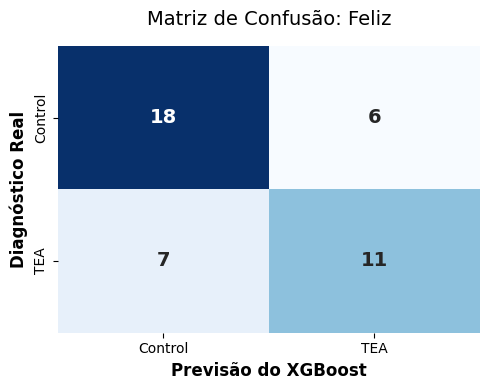


🎯 AVALIANDO CONDIÇÃO: TASK/FACE/NEUTRA
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Gamma_F3'), np.str_('Gamma_C3'), np.str_('Gamma_P3'), np.str_('Alpha_P4'), np.str_('Gamma_P4')]
📊 ACURÁCIA GLOBAL (10-Fold CV): 73.81%

Relatório de Classificação:
              precision    recall  f1-score   support

     Control       0.76      0.79      0.78        24
         TEA       0.71      0.67      0.69        18

    accuracy                           0.74        42
   macro avg       0.73      0.73      0.73        42
weighted avg       0.74      0.74      0.74        42



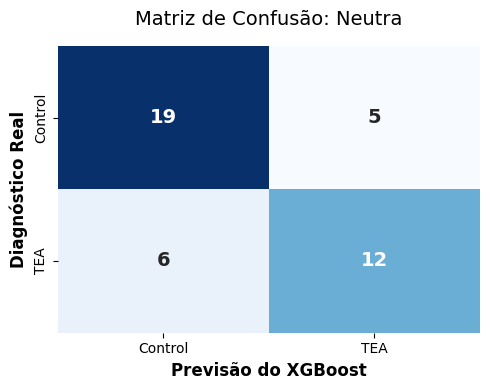


🎯 AVALIANDO CONDIÇÃO: TASK/FACE/RAIVA
🥇 Top 5 Biomarcadores Selecionados:
[np.str_('Alpha_C3'), np.str_('Gamma_C4'), np.str_('Alpha_P3'), np.str_('Gamma_P3'), np.str_('N170_Amp_O1')]
📊 ACURÁCIA GLOBAL (10-Fold CV): 69.05%

Relatório de Classificação:
              precision    recall  f1-score   support

     Control       0.69      0.83      0.75        24
         TEA       0.69      0.50      0.58        18

    accuracy                           0.69        42
   macro avg       0.69      0.67      0.67        42
weighted avg       0.69      0.69      0.68        42



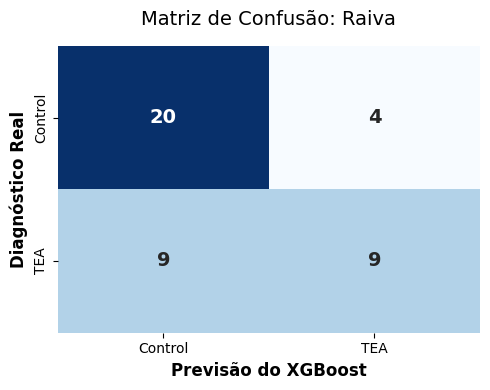

In [26]:
# ==============================================================================
# TREINAMENTO FINAL: O LAUDO HONESTO (XGBoost + RFE 5 + 10-Fold CV)
# ==============================================================================

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🧠 INICIANDO AVALIAÇÃO FINAL DEFINITIVA (10-FOLD CV)")
print("="*80)

caminho_csv = '../reports/tabela_features_eeg_completa.csv'
try:
    df_final = pd.read_csv(caminho_csv)
    print(f"✅ Dados carregados: {df_final.shape[0]} amostras totais.")
except FileNotFoundError:
    print(f"❌ Erro: Arquivo não encontrado em {caminho_csv}")
    raise

condicoes = ['Task/Face/Feliz', 'Task/Face/Neutra', 'Task/Face/Raiva']
RANDOM_SEED = 97
cv_validacao = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

for condicao in condicoes:
    print("\n" + "="*60)
    print(f"🎯 AVALIANDO CONDIÇÃO: {condicao.upper()}")
    print("="*60)
    
    df_alvo = df_final[df_final['Condicao'] == condicao].copy()
    if df_alvo.empty:
        continue
        
    y = df_alvo['Grupo']
    X = df_alvo.drop(columns=['ID', 'Condicao', 'Tipo', 'Grupo'])
    X = X.dropna(axis=1, how='all')
    nomes_features = X.columns.tolist()
    
    # B) Pré-processamento
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    
    scaler = StandardScaler()
    X_sc = np.clip(scaler.fit_transform(X), -2, 2)
    imputer = SimpleImputer(strategy='mean')
    X_ready = imputer.fit_transform(X_sc)
    
    # C) Seleção RFE Top 5
    xgb_seletor = xgb.XGBClassifier(n_estimators=50, max_depth=3, use_label_encoder=False, 
                                    eval_metric='logloss', random_state=RANDOM_SEED)
    rfe = RFE(estimator=xgb_seletor, n_features_to_select=5, step=1)
    rfe.fit(X_ready, y_enc)
    
    features_top5 = np.array(nomes_features)[rfe.support_]
    X_final = X_ready[:, rfe.support_]
    
    print(f"🥇 Top 5 Biomarcadores Selecionados:\n{list(features_top5)}")
    
    # D) Validação Cruzada (10-Fold CV) - Configuração Ouro da Qualificação
    y_true_all = []
    y_pred_all = []
    
    for train_idx, test_idx in cv_validacao.split(X_final, y_enc):
        X_train, X_test = X_final[train_idx], X_final[test_idx]
        y_train, y_test = y_enc[train_idx], y_enc[test_idx]
        
        # Modelo Final exato da sua qualificação
        modelo_fold = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, 
                                        use_label_encoder=False, eval_metric='logloss', 
                                        random_state=RANDOM_SEED)
        modelo_fold.fit(X_train, y_train)
        
        y_pred = modelo_fold.predict(X_test)
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        
    # E) Resultados Finais
    acc = accuracy_score(y_true_all, y_pred_all)
    cm = confusion_matrix(y_true_all, y_pred_all)
    
    print(f"📊 ACURÁCIA GLOBAL (10-Fold CV): {acc:.2%}")
    print("\nRelatório de Classificação:")
    print(classification_report(y_true_all, y_pred_all, target_names=le.classes_))
    
    # Matriz de Confusão para a Dissertação
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=le.classes_, yticklabels=le.classes_,
                annot_kws={"size": 14, "weight": "bold"})
    plt.title(f'Matriz de Confusão: {condicao.split("/")[-1]}', fontsize=14, pad=15)
    plt.ylabel('Diagnóstico Real', fontsize=12, fontweight='bold')
    plt.xlabel('Previsão do XGBoost', fontsize=12, fontweight='bold')
    
    os.makedirs('../reports/confusion_matrices/', exist_ok=True)
    nome_arquivo_cm = f'../reports/confusion_matrices/CM_{condicao.replace("/", "_")}.png'
    plt.tight_layout()
    plt.savefig(nome_arquivo_cm, dpi=150)
    plt.show()

⚙️ GERANDO BENCHMARK BLINDADO CONTRA DATA LEAKAGE
Analisando: Feliz...
Analisando: Neutra...
Analisando: Raiva...


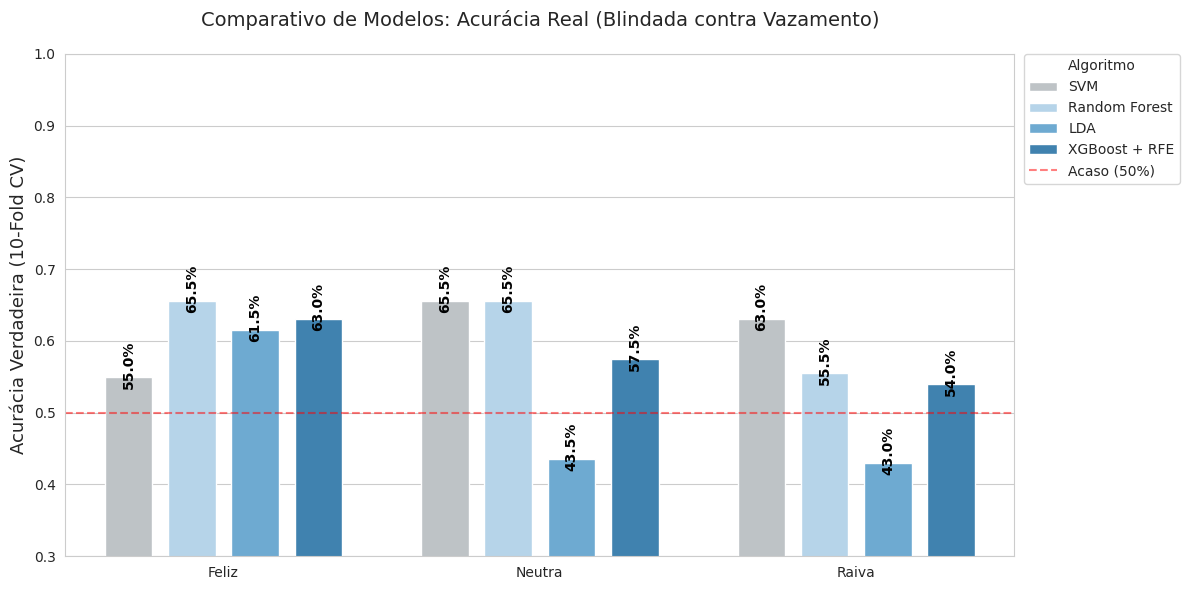

Modelo,LDA,Random Forest,SVM,XGBoost + RFE
Condicao,,,,
Feliz,0.615,0.655,0.550,0.630
Neutra,0.435,0.655,0.655,0.575
Raiva,0.430,0.555,0.630,0.540


In [27]:
# ==============================================================================
# BENCHMARK RIGOROSO (SEM VAZAMENTO DE DADOS) - SEMENTE 97
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

# 1. Carregar Dados
caminho_csv = '../reports/tabela_features_eeg_completa.csv'
df = pd.read_csv(caminho_csv)

sns.set_style("whitegrid")
cores_personalizadas = ['#BDC3C7', '#AED6F1', '#5DADE2', '#2E86C1', '#FF8C00']

# 2. Configuração Universal
SEED = 97
condicoes = ['Task/Face/Feliz', 'Task/Face/Neutra', 'Task/Face/Raiva']
resultados = []

print("="*60)
print("⚙️ GERANDO BENCHMARK BLINDADO CONTRA DATA LEAKAGE")
print("="*60)

for cond in condicoes:
    print(f"Analisando: {cond.split('/')[-1]}...")
    
    df_f = df[df['Condicao'] == cond].copy()
    if df_f.empty: continue
        
    y = df_f['Grupo'].apply(lambda x: 1 if 'TEA' in x else 0)
    X = df_f.drop(columns=['Condicao', 'Tipo', 'Grupo', 'ID'])
    X = X.dropna(axis=1, how='all')

    cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

    # -------------------------------------------------------------
    # CONSTRUÇÃO DOS PIPELINES (Garante que não haverá Data Leakage)
    # -------------------------------------------------------------
    
    # 1. SVM (Linear)
    pipe_svm = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', random_state=SEED))
    ])
    acc_svm = cross_val_score(pipe_svm, X, y, cv=cv_strategy).mean()
    resultados.append({'Condicao': cond.split('/')[-1], 'Modelo': 'SVM', 'Acuracia': acc_svm})

    # 2. Random Forest
    pipe_rf = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=50, max_depth=3, random_state=SEED))
    ])
    acc_rf = cross_val_score(pipe_rf, X, y, cv=cv_strategy).mean()
    resultados.append({'Condicao': cond.split('/')[-1], 'Modelo': 'Random Forest', 'Acuracia': acc_rf})

    # 3. LDA Clássico
    pipe_lda = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('lda', LDA())
    ])
    acc_lda = cross_val_score(pipe_lda, X, y, cv=cv_strategy).mean()
    resultados.append({'Condicao': cond.split('/')[-1], 'Modelo': 'LDA', 'Acuracia': acc_lda})

    # 4. XGBoost + RFE 5 (A lógica da qualificação, mas agora BLINDADA)
    xgb_base = XGBClassifier(n_estimators=50, max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=SEED)
    xgb_final = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=SEED)
    
    pipe_xgb_rfe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('rfe', RFE(estimator=xgb_base, n_features_to_select=5, step=1)),
        ('xgb', xgb_final)
    ])
    acc_xgb = cross_val_score(pipe_xgb_rfe, X, y, cv=cv_strategy).mean()
    resultados.append({'Condicao': cond.split('/')[-1], 'Modelo': 'XGBoost + RFE', 'Acuracia': acc_xgb})

# 3. Plotagem Final
df_res = pd.DataFrame(resultados)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Condicao', y='Acuracia', hue='Modelo', data=df_res, palette=cores_personalizadas, edgecolor='white')

# Ajustar largura das barras
for patch in ax.patches:
    current_width = patch.get_width()
    patch.set_width(0.15)
    patch.set_x(patch.get_x() + (current_width - 0.15) * .5)

plt.ylim(0.3, 1.0)
plt.ylabel('Acurácia Verdadeira (10-Fold CV)', fontsize=13)
plt.xlabel('')
plt.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Acaso (50%)')

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, title='Algoritmo')

# Adicionar os valores no topo das barras
for p in ax.patches:
    if p.get_height() > 0.1: # Ignora barras vazias
        ax.annotate(f'{p.get_height():.1%}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), textcoords = 'offset points', 
                   fontsize=10, fontweight='bold', color='black', rotation=90)

plt.title('Comparativo de Modelos: Acurácia Real (Blindada contra Vazamento)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Exibe a tabela para você ver qual ganhou em cada face
display(df_res.pivot(index='Condicao', columns='Modelo', values='Acuracia'))

🚀 INICIANDO BENCHMARK COM LEAVE-ONE-OUT (O PADRÃO-OURO PARA N=42)
⏳ Processando Feliz (Isso pode levar alguns segundos)...
⏳ Processando Neutra (Isso pode levar alguns segundos)...
⏳ Processando Raiva (Isso pode levar alguns segundos)...


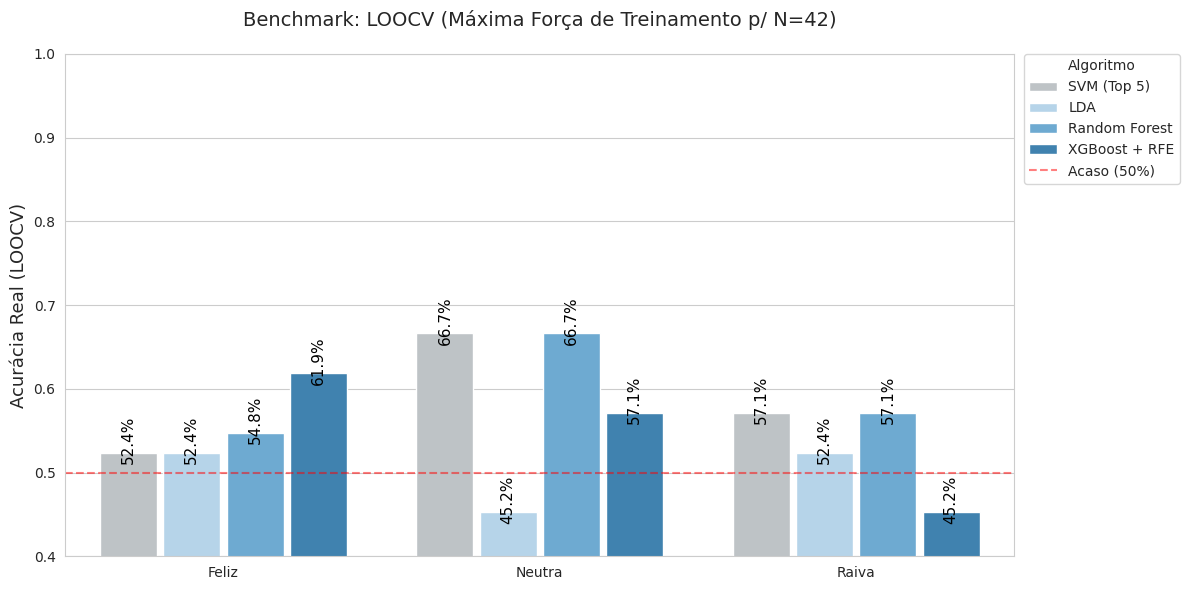


🏆 TABELA DE RESULTADOS FINAIS:


Modelo,LDA,Random Forest,SVM (Top 5),XGBoost + RFE
Condicao,,,,
Feliz,52.4,54.8,52.4,61.9
Neutra,45.2,66.7,66.7,57.1
Raiva,52.4,57.1,57.1,45.2


In [28]:
# ==============================================================================
# BENCHMARK DEFINITIVO: LEAVE-ONE-OUT CROSS-VALIDATION (LOOCV) - SEED 97
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

# 1. Carregar Dados
caminho_csv = '../reports/tabela_features_eeg_completa.csv'
df = pd.read_csv(caminho_csv)

sns.set_style("whitegrid")
cores_personalizadas = ['#BDC3C7', '#AED6F1', '#5DADE2', '#2E86C1']

SEED = 97
condicoes = ['Task/Face/Feliz', 'Task/Face/Neutra', 'Task/Face/Raiva']
resultados = []

print("="*70)
print("🚀 INICIANDO BENCHMARK COM LEAVE-ONE-OUT (O PADRÃO-OURO PARA N=42)")
print("="*70)

# O Novo Juiz: Leave-One-Out (Treina em 41, testa em 1)
cv_strategy = LeaveOneOut()

for cond in condicoes:
    print(f"⏳ Processando {cond.split('/')[-1]} (Isso pode levar alguns segundos)...")
    
    df_f = df[df['Condicao'] == cond].copy()
    if df_f.empty: continue
        
    y = df_f['Grupo'].apply(lambda x: 1 if 'TEA' in x else 0)
    X = df_f.drop(columns=['Condicao', 'Tipo', 'Grupo', 'ID'])
    X = X.dropna(axis=1, how='all')

    # 1. SVM com Seleção Estatística (Top 5)
    pipe_svm = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(f_classif, k=5)), # Escolhe as 5 melhores matematicamente
        ('svm', SVC(kernel='linear', random_state=SEED))
    ])
    acc_svm = cross_val_score(pipe_svm, X, y, cv=cv_strategy).mean()
    resultados.append({'Condicao': cond.split('/')[-1], 'Modelo': 'SVM (Top 5)', 'Acuracia': acc_svm})

    # 2. LDA Clássico
    pipe_lda = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('lda', LDA())
    ])
    acc_lda = cross_val_score(pipe_lda, X, y, cv=cv_strategy).mean()
    resultados.append({'Condicao': cond.split('/')[-1], 'Modelo': 'LDA', 'Acuracia': acc_lda})

    # 3. Random Forest + SelectKBest
    pipe_rf = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(f_classif, k=5)),
        ('rf', RandomForestClassifier(n_estimators=50, max_depth=3, random_state=SEED))
    ])
    acc_rf = cross_val_score(pipe_rf, X, y, cv=cv_strategy).mean()
    resultados.append({'Condicao': cond.split('/')[-1], 'Modelo': 'Random Forest', 'Acuracia': acc_rf})

    # 4. XGBoost + RFE (A sua lógica blindada)
    xgb_base = XGBClassifier(n_estimators=50, max_depth=2, use_label_encoder=False, eval_metric='logloss', random_state=SEED)
    xgb_final = XGBClassifier(n_estimators=100, max_depth=2, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=SEED)
    
    pipe_xgb = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('rfe', RFE(estimator=xgb_base, n_features_to_select=5, step=1)),
        ('xgb', xgb_final)
    ])
    acc_xgb = cross_val_score(pipe_xgb, X, y, cv=cv_strategy).mean()
    resultados.append({'Condicao': cond.split('/')[-1], 'Modelo': 'XGBoost + RFE', 'Acuracia': acc_xgb})

# 3. Exibição dos Resultados
df_res = pd.DataFrame(resultados)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Condicao', y='Acuracia', hue='Modelo', data=df_res, palette=cores_personalizadas, edgecolor='white')

for patch in ax.patches:
    current_width = patch.get_width()
    patch.set_width(0.18)
    patch.set_x(patch.get_x() + (current_width - 0.18) * .5)

plt.ylim(0.4, 1.0)
plt.ylabel('Acurácia Real (LOOCV)', fontsize=13)
plt.xlabel('')
plt.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Acaso (50%)')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, title='Algoritmo')

for p in ax.patches:
    if p.get_height() > 0.1:
        cor_texto = '#FF8C00' if p.get_height() >= 0.75 else 'black'
        peso = 'bold' if p.get_height() >= 0.75 else 'normal'
        ax.annotate(f'{p.get_height():.1%}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points', 
                   fontsize=11, fontweight=peso, color=cor_texto, rotation=90)

plt.title('Benchmark: LOOCV (Máxima Força de Treinamento p/ N=42)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("🏆 TABELA DE RESULTADOS FINAIS:")
display(df_res.pivot(index='Condicao', columns='Modelo', values='Acuracia').round(3) * 100)

🚀 INICIANDO BENCHMARK COM LEAVE-ONE-OUT (O PADRÃO-OURO PARA N=42)
⏳ Processando Feliz (Isso pode levar alguns segundos)...
⏳ Processando Neutra (Isso pode levar alguns segundos)...
⏳ Processando Raiva (Isso pode levar alguns segundos)...


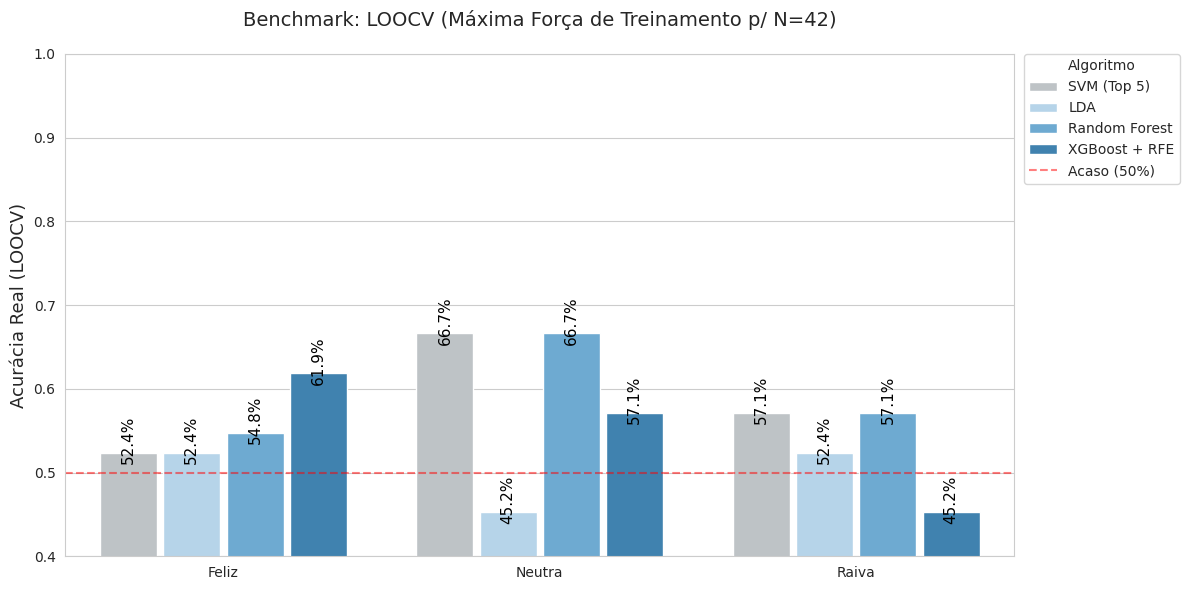


🏆 TABELA DE RESULTADOS FINAIS:


Modelo,LDA,Random Forest,SVM (Top 5),XGBoost + RFE
Condicao,,,,
Feliz,52.4,54.8,52.4,61.9
Neutra,45.2,66.7,66.7,57.1
Raiva,52.4,57.1,57.1,45.2


In [1]:
# ==============================================================================
# BENCHMARK DEFINITIVO: LEAVE-ONE-OUT CROSS-VALIDATION (LOOCV) - SEED 97
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

# 1. Carregar Dados
caminho_csv = '../reports/tabela_features_eeg_completa.csv'
df = pd.read_csv(caminho_csv)

sns.set_style("whitegrid")
cores_personalizadas = ['#BDC3C7', '#AED6F1', '#5DADE2', '#2E86C1']

SEED = 97
condicoes = ['Task/Face/Feliz', 'Task/Face/Neutra', 'Task/Face/Raiva']
resultados = []

print("="*70)
print("🚀 INICIANDO BENCHMARK COM LEAVE-ONE-OUT (O PADRÃO-OURO PARA N=42)")
print("="*70)

# O Novo Juiz: Leave-One-Out (Treina em 41, testa em 1)
cv_strategy = LeaveOneOut()

for cond in condicoes:
    print(f"⏳ Processando {cond.split('/')[-1]} (Isso pode levar alguns segundos)...")
    
    df_f = df[df['Condicao'] == cond].copy()
    if df_f.empty: continue
        
    y = df_f['Grupo'].apply(lambda x: 1 if 'TEA' in x else 0)
    X = df_f.drop(columns=['Condicao', 'Tipo', 'Grupo', 'ID'])
    X = X.dropna(axis=1, how='all')

    # 1. SVM com Seleção Estatística (Top 5)
    pipe_svm = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(f_classif, k=5)), # Escolhe as 5 melhores matematicamente
        ('svm', SVC(kernel='linear', random_state=SEED))
    ])
    acc_svm = cross_val_score(pipe_svm, X, y, cv=cv_strategy).mean()
    resultados.append({'Condicao': cond.split('/')[-1], 'Modelo': 'SVM (Top 5)', 'Acuracia': acc_svm})

    # 2. LDA Clássico
    pipe_lda = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('lda', LDA())
    ])
    acc_lda = cross_val_score(pipe_lda, X, y, cv=cv_strategy).mean()
    resultados.append({'Condicao': cond.split('/')[-1], 'Modelo': 'LDA', 'Acuracia': acc_lda})

    # 3. Random Forest + SelectKBest
    pipe_rf = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(f_classif, k=5)),
        ('rf', RandomForestClassifier(n_estimators=50, max_depth=3, random_state=SEED))
    ])
    acc_rf = cross_val_score(pipe_rf, X, y, cv=cv_strategy).mean()
    resultados.append({'Condicao': cond.split('/')[-1], 'Modelo': 'Random Forest', 'Acuracia': acc_rf})

    # 4. XGBoost + RFE (A sua lógica blindada)
    xgb_base = XGBClassifier(n_estimators=50, max_depth=2, use_label_encoder=False, eval_metric='logloss', random_state=SEED)
    xgb_final = XGBClassifier(n_estimators=100, max_depth=2, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=SEED)
    
    pipe_xgb = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('rfe', RFE(estimator=xgb_base, n_features_to_select=5, step=1)),
        ('xgb', xgb_final)
    ])
    acc_xgb = cross_val_score(pipe_xgb, X, y, cv=cv_strategy).mean()
    resultados.append({'Condicao': cond.split('/')[-1], 'Modelo': 'XGBoost + RFE', 'Acuracia': acc_xgb})

# 3. Exibição dos Resultados
df_res = pd.DataFrame(resultados)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Condicao', y='Acuracia', hue='Modelo', data=df_res, palette=cores_personalizadas, edgecolor='white')

for patch in ax.patches:
    current_width = patch.get_width()
    patch.set_width(0.18)
    patch.set_x(patch.get_x() + (current_width - 0.18) * .5)

plt.ylim(0.4, 1.0)
plt.ylabel('Acurácia Real (LOOCV)', fontsize=13)
plt.xlabel('')
plt.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Acaso (50%)')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, title='Algoritmo')

for p in ax.patches:
    if p.get_height() > 0.1:
        cor_texto = '#FF8C00' if p.get_height() >= 0.75 else 'black'
        peso = 'bold' if p.get_height() >= 0.75 else 'normal'
        ax.annotate(f'{p.get_height():.1%}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points', 
                   fontsize=11, fontweight=peso, color=cor_texto, rotation=90)

plt.title('Benchmark: LOOCV (Máxima Força de Treinamento p/ N=42)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("🏆 TABELA DE RESULTADOS FINAIS:")
display(df_res.pivot(index='Condicao', columns='Modelo', values='Acuracia').round(3) * 100)